# Lab Assignment 6: perform experiments with CIFAR100

## Checking Avilable GPU

In [11]:
!nvidia-smi

Sun Apr  2 21:48:54 2023       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 525.89.02    Driver Version: 525.89.02    CUDA Version: 12.0     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  NVIDIA GeForce ...  Off  | 00000000:01:00.0  On |                  N/A |
|  0%   55C    P8    38W / 350W |    226MiB / 24576MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## Importing requirements

In [12]:
# pytorch libs
import torch
from torch import nn
import torchvision

# matplot libs
import matplotlib.pyplot as plt

# numpy
import numpy as np

# torch metrics
try:
  import torchmetrics
except:
  !pip3 -q install torchmetrics
import torchmetrics
from torchmetrics.classification import Accuracy

try:
  import torchinfo
except:
  !pip3 -q install torchinfo
finally:
  from torchinfo import summary

try:
  import torchattacks
except:
  !pip3 -q install torchattacks
finally:
  import torchattacks

## device agnostic code

In [13]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cuda'

## Model Defination

### ResNet-34

In [14]:
from torchvision.models import resnet34
# Model with pretrained weights Architecture - Resnet18resnet18
def get_resnet_model():
    model_resnet = resnet34()

    model_resnet.fc = nn.Linear(512, 100)
    
    return model_resnet

### DenseNet-121

In [15]:
from torchvision.models import densenet121
# Model with pretrained weights Architecture - Resnet18resnet18
def get_densenet_model():
    model_densenet = densenet121()

    model_densenet.classifier = nn.Linear(1024, 100)
    
    return model_densenet

### EfficientNet-B0

In [16]:
from torchvision.models import efficientnet_b0
# Model with pretrained weights Architecture - Resnet18resnet18

def get_effnet_model():
    model_effnet = efficientnet_b0()

    model_effnet.classifier = nn.Sequential(
        nn.Dropout(p=0.2, inplace=True),
        nn.Linear(in_features=1280, out_features=100, bias=True)
    )
    
    return model_effnet

### ConvNeXt-T

In [17]:
from torchvision.models import convnext_tiny
# Model with pretrained weights Architecture - Resnet18resnet18
model_convnext = convnext_tiny()
print(model_convnext.classifier)
def get_convnext_model():
    model_convnext = convnext_tiny()

    model_convnext.classifier = nn.Sequential(
        # nn.LayerNorm([128,768,1,1], eps=1e-06, elementwise_affine=True),
        nn.Flatten(start_dim=1, end_dim=-1),
        nn.Linear(in_features=768, out_features=100, bias=True)
    )
    
    return model_convnext

Sequential(
  (0): LayerNorm2d((768,), eps=1e-06, elementwise_affine=True)
  (1): Flatten(start_dim=1, end_dim=-1)
  (2): Linear(in_features=768, out_features=1000, bias=True)
)


## Getting Dataset with pytorch


### Downloading the dataset

In [18]:
from torchvision import transforms

data_transforms_train = transforms.Compose([
    transforms.TrivialAugmentWide(num_magnitude_bins=31),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
])

data_transforms_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
])

train_dataset = torchvision.datasets.CIFAR100(
    root='data',
    train=True,
    download=True,
    transform=data_transforms_train,
)

test_dataset = torchvision.datasets.CIFAR100(
    root='data',
    train=False,
    download=True,
    transform=data_transforms_test,
)
train_dataset, test_dataset

Files already downloaded and verified
Files already downloaded and verified


(Dataset CIFAR100
     Number of datapoints: 50000
     Root location: data
     Split: Train
     StandardTransform
 Transform: Compose(
                TrivialAugmentWide(num_magnitude_bins=31, interpolation=InterpolationMode.NEAREST, fill=None)
                ToTensor()
                Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
            ),
 Dataset CIFAR100
     Number of datapoints: 10000
     Root location: data
     Split: Test
     StandardTransform
 Transform: Compose(
                ToTensor()
                Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761])
            ))

### Vis. dataset (train dataset)

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


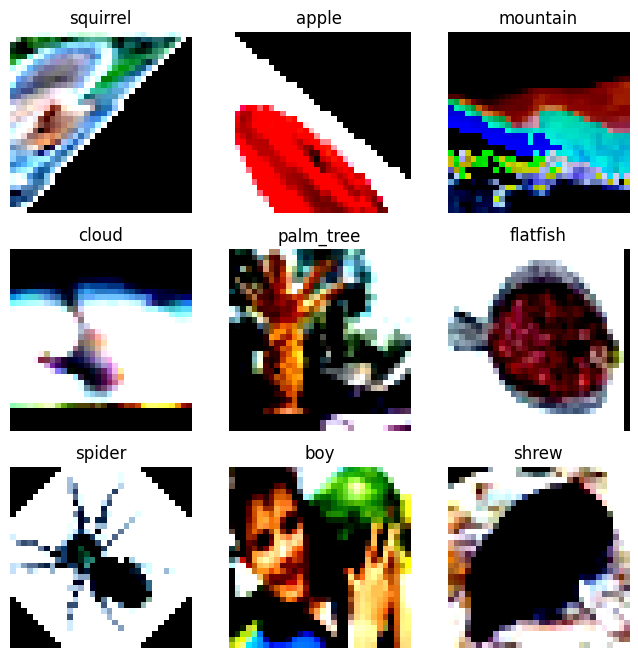

In [19]:
# randomly ploting image samples from the grayscale dataset
classes = train_dataset.classes
labels_map = {classes[i]:i for i in range(100)}  # getting class -> index map
labels_map = dict(map(reversed, labels_map.items()))  # inverting dict
# print(labels_map)

figure = plt.figure(figsize=(8, 8))  # fixing plotsize
cols, rows = 3, 3
for i in range(1, cols * rows + 1):
    sample_idx = torch.randint(
        len(train_dataset), size=(1,)
    )  # randomely selecting one image sample from the image index
    img, label = train_dataset[sample_idx]  # getting image and label of selected index
    # sub plot code
    figure.add_subplot(rows, cols, i)
    plt.title(labels_map[label])
    plt.axis("off")
    plt.imshow(
        img.permute(1, 2, 0)
    )  # NOTE:- Color map is gray because we're converting imgae to grayscale / changing channel to HWC for color image
    # sub plot code ends
plt.show()
# NOTE: WARRING BECAUSE OF auto_transforms

### Converting dataset to dataloader

In [20]:
import os

# hyper parms. for dataloader
BATCH_SIZE = 128
NUM_WORKERS = os.cpu_count()//2  # no. of avilable cpu cores

# train dataloader
train_dataloader = torch.utils.data.DataLoader(
    dataset=train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=NUM_WORKERS
)

# test dataloader
test_dataloader = torch.utils.data.DataLoader(
    dataset=test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=NUM_WORKERS
)

print(f"Numbers of Batches in Train Dataloader: {len(train_dataloader)}")
print(f"Numbers of Batches in Test Dataloader: {len(test_dataloader)}")
# train_dataloader,test_dataloader

Numbers of Batches in Train Dataloader: 391
Numbers of Batches in Test Dataloader: 79


## Models Training Utils Functions

### Plot loss curves of a model

In [21]:
# Plot loss curves of a model
def plot_loss_curves(results):
    """Plots training curves of a results dictionary.

    Args:
        results (dict): dictionary containing list of values, e.g.
            {"train_loss": [...],
             "train_acc": [...],
             "test_loss": [...],
             "test_acc": [...]}
    """
    loss = results["train_loss"]
    test_loss = results["test_loss"]

    accuracy = results["train_acc"]
    test_accuracy = results["test_acc"]

    epochs = range(len(results["train_loss"]))

    plt.figure(figsize=(15, 7))

    # Plot loss
    plt.subplot(1, 2, 1)
    plt.plot(epochs, loss, label="train_loss")
    plt.plot(epochs, test_loss, label="test_loss")
    plt.title("Loss")
    plt.xlabel("Epochs")
    plt.legend()

    # Plot accuracy
    plt.subplot(1, 2, 2)
    plt.plot(epochs, accuracy, label="train_accuracy")
    plt.plot(epochs, test_accuracy, label="test_accuracy")
    plt.title("Accuracy")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()

### making training, testing steps, train model functions

#### train step

In [22]:
def training_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    device: str,
    profiler: torch.profiler.profile = None,
):
    """
    Desc:
      funtion to perform traning step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      optimizer (torch.optim.Optimizer): Optimizer Function (object) of your choice
      device (str): Torch Device "CPU/GPU"
      profiler (torch.profiler.profile, optional): Pytorch Profiler. Defaults to None.
    Returns:
      train_loss (float), train_acc (float): training loss and training accuracy for one EPOCH
    """
    model.train()  # putting model in traing model

    train_loss, train_acc = 0, 0  # initlizing loss and acc. for the epoch

    if profiler != None:
      profiler.start()
      for step,(X, y) in enumerate(dataloader):  # loop in batches
        if step >= (1 + 1 + 3) * 2:
          break
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        train_acc += acc_fn(y_pred_logits, y).item()
        
        profiler.step()
      profiler.stop()
    else:
      for step,(X, y) in enumerate(dataloader):  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")
        
        # 1. forward pass
        y_pred_logits = model(X)
        # y_pred = y_pred_logits.argmax(dim=1).type(torch.int)
        # print(y_pred)
        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        train_loss += loss.item()

        # 3. optimizer zero grad
        optimizer.zero_grad()

        # 4. loss backword
        loss.backward()

        # 5. optimizer step
        optimizer.step()
        
        train_acc += acc_fn(y_pred_logits, y).item()
    # 6. returning actual loss and acc.x
    return train_loss / len(dataloader), train_acc / len(dataloader)

#### test step

In [23]:
def testing_step(
    model: nn.Module,
    dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    device: str,
):
    """
    Desc:
      funtion to perform testing step for one EPOCH

    Args:
      model (nn.Module): Pytorch model class object
      dataloader (torch.utils.data.DataLoader): testing dataloder from training dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
    Returns:
      test_loss (float), test_acc (float): testing loss and testing accuracy for one EPOCH
    """
    model.eval()  # putting model in eval model

    test_loss, test_acc = 0, 0  # initlizing loss and acc. for the epoch

    # with torch.inference_mode(): # disabling inference mode for aqcuiring gradients of perturbed data
    for (X, y) in dataloader:  # loop in batches
        X, y = X.to(device), y.to(device)  # sending the data to target device
        # print(f"shape of X: {X.shape}, shape of y: {y.shape}")

        # 1. forward pass
        y_pred_logits = model(X)

        # 2. calculate the loss
        loss = loss_fn(y_pred_logits, y)
        test_loss += loss.item()

        # printing the prediction and actual label
        # print(y_pred_logits.argmax(dim=1), y,sep='\n')
        
        # 3. calculating accuracy
        test_acc += acc_fn(y_pred_logits, y).item()

    # 6. returning actual loss and acc.
    return test_loss / len(dataloader), test_acc / len(dataloader)

#### training function

In [24]:
from tqdm.auto import tqdm


def train(
    model: nn.Module,
    train_dataloader: torch.utils.data.DataLoader,
    test_dataloader: torch.utils.data.DataLoader,
    loss_fn: nn.Module,
    acc_fn: torchmetrics.classification.accuracy.MulticlassAccuracy,
    optimizer: torch.optim.Optimizer,
    epochs: int,
    save_info: str,
    profiler:torch.profiler.profile = None,
):
    """
    Desc:
      funtion to perform training for one {epochs} param

    Args:
      model (nn.Module): Pytorch model class object
      train_dataloader (torch.utils.data.DataLoader): training dataloder from training dataset
      test_dataloader (torch.utils.data.DataLoader): testing dataloder from testing dataset
      loss_fn (nn.Module): Loss Function (object) of your choice
      acc_fn (torchmetrics.classification.accuracy.MulticlassAccuracy): accuracy function from trochmetrics
      device (str): Torch Device "CPU/GPU"
      epochs (int): number of epochs to train the model
      save_info (str): info for saving model
      profiler (torch.profiler.profile, optional): Pytorch Profiler. Defaults to None.
    Returns:
      result_dict ({str: List[float]}): testing loss and testing accuracy for one EPOCH
    """
    # 1. init. result dict
    result_dict = {"train_loss": [], "train_acc": [], "test_loss": [], "test_acc": []}
    best_test_acc = 0
    best_model_params = None

    # 2. loop in range epochs performs train and test steps on the model
    for epoch in tqdm(range(epochs)):
        train_loss, train_acc = training_step(
            model=model,
            dataloader=train_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            optimizer=optimizer,
            device=device,
            profiler=profiler,
        )

        test_loss, test_acc = testing_step(
            model=model,
            dataloader=test_dataloader,
            loss_fn=loss_fn,
            acc_fn=acc_fn,
            device=device,
        )

        # 3. print out results
        print(
            f"Epoch: {epoch+1} | "
            f"train_loss: {train_loss:.4f} | "
            f"train_acc: {train_acc:.4f} | "
            f"test_loss: {test_loss:.4f} | "
            f"test_acc: {test_acc:.4f}"
        )

        # 4. adding results to result_dict
        result_dict["train_loss"].append(train_loss)
        result_dict["train_acc"].append(train_acc)
        result_dict["test_loss"].append(test_loss)
        result_dict["test_acc"].append(test_acc)
        
        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_params = model.state_dict()

    # 5. saving the best model
    torch.save(best_model_params, f"{model.__class__.__name__}_epoch_{epochs}_optim_adam_"+save_info+".pth")
    # 6. return result dict
    return result_dict

## Training the models

### Training ResNet-34

In [25]:
# # Hyperparms
# lr = [1e-3,1e-4] # learning rate
# betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
# weight_decay = [1e-3] # weight decay (L2 penalty)

# Best parms: Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001
lr = [1e-4] # learning rate
betas=[(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)

parms_combs = [(l,b,e,w_d) for l in lr for b in betas for e in eps for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 50

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=100).to(device=device)

#### Profiling

current exp / total: 1 / 1
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

STAGE:2023-04-02 21:49:01 1994106:1994106 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-04-02 21:49:01 1994106:1994106 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-04-02 21:49:04 1994106:1994106 output_json.cpp:417] Completed Stage: Post Processing
STAGE:2023-04-02 21:49:04 1994106:1994106 ActivityProfilerController.cpp:294] Completed Stage: Warm Up
STAGE:2023-04-02 21:49:05 1994106:1994106 ActivityProfilerController.cpp:300] Completed Stage: Collection
STAGE:2023-04-02 21:49:08 1994106:1994106 output_json.cpp:417] Completed Stage: Post Processing


Epoch: 1 | train_loss: 0.1260 | train_acc: 0.0003 | test_loss: 4.6238 | test_acc: 0.0093
Epoch: 2 | train_loss: 0.1222 | train_acc: 0.0002 | test_loss: 4.6303 | test_acc: 0.0113
Epoch: 3 | train_loss: 0.1216 | train_acc: 0.0004 | test_loss: 4.5998 | test_acc: 0.0185
Epoch: 4 | train_loss: 0.1198 | train_acc: 0.0005 | test_loss: 4.5723 | test_acc: 0.0262
Epoch: 5 | train_loss: 0.1185 | train_acc: 0.0007 | test_loss: 4.5302 | test_acc: 0.0328
Epoch: 6 | train_loss: 0.1184 | train_acc: 0.0009 | test_loss: 4.4974 | test_acc: 0.0424
Epoch: 7 | train_loss: 0.1180 | train_acc: 0.0007 | test_loss: 4.4623 | test_acc: 0.0416
Epoch: 8 | train_loss: 0.1167 | train_acc: 0.0010 | test_loss: 4.4043 | test_acc: 0.0448
Epoch: 9 | train_loss: 0.1164 | train_acc: 0.0007 | test_loss: 4.3640 | test_acc: 0.0466
Epoch: 10 | train_loss: 0.1148 | train_acc: 0.0009 | test_loss: 4.3496 | test_acc: 0.0458
Epoch: 11 | train_loss: 0.1147 | train_acc: 0.0009 | test_loss: 4.2948 | test_acc: 0.0548
Epoch: 12 | train_l

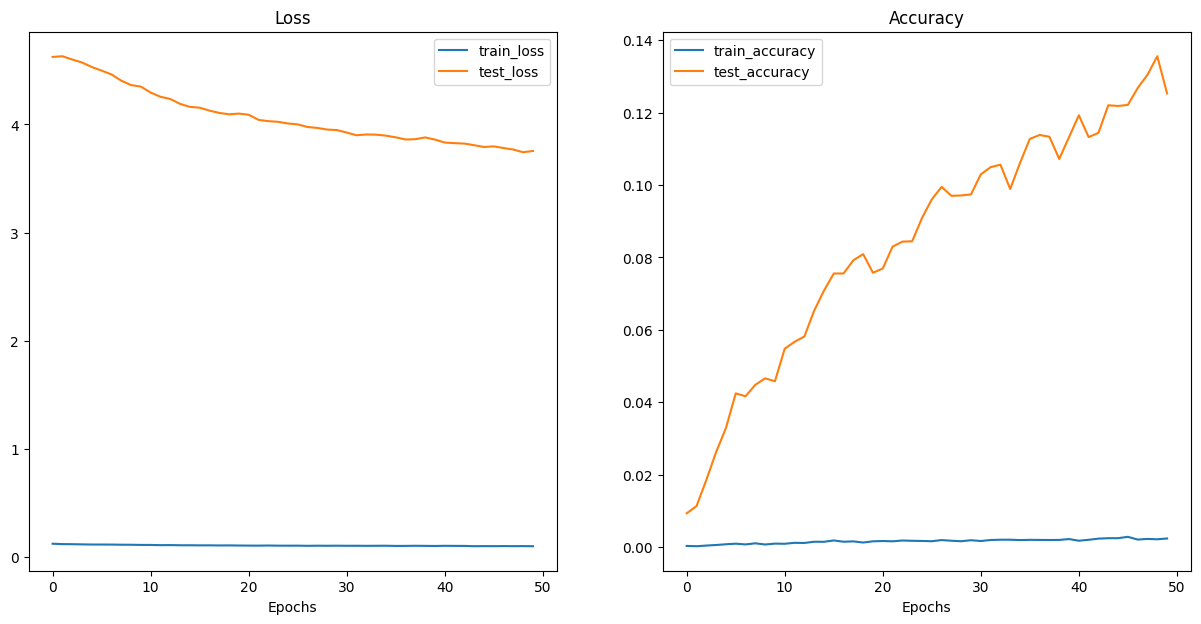

In [26]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_resnet = get_resnet_model().to(device=device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_resnet.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  
  # creating profiler
  prof = torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('log/resnet34'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
        )
  # train model
  model_resnet_results = train(
      model=model_resnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_info=f"lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}",
      profiler=prof
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_resnet_results)
  cur+=1
  print()

In [ ]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_resnet = get_resnet_model().to(device=device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_resnet.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  
  # creating profiler
  prof = torch.profiler.profile(
        schedule=torch.profiler.schedule(wait=1, warmup=1, active=3, repeat=2),
        on_trace_ready=torch.profiler.tensorboard_trace_handler('log/resnet34'),
        record_shapes=True,
        profile_memory=True,
        with_stack=True
        )
  # train model
  model_resnet_results = train(
      model=model_resnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_info=f"lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}",
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_resnet_results)
  cur+=1
  print()

### DenseNet-121

In [32]:
# Hyperparms
# lr = [1e-3,1e-4] # learning rate
# betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
# weight_decay = [1e-3] # weight decay (L2 penalty)

# Best parms: Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001
lr = [1e-4] # learning rate
betas=[(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)

parms_combs = [(l,b,e,w_d) for l in lr for b in betas for e in eps for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 50

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=100).to(device=device)

current exp / total: 1 / 1
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.3133 | train_acc: 0.0569 | test_loss: 3.8488 | test_acc: 0.1305
Epoch: 2 | train_loss: 3.9578 | train_acc: 0.1067 | test_loss: 3.5097 | test_acc: 0.1830
Epoch: 3 | train_loss: 3.7550 | train_acc: 0.1367 | test_loss: 3.2879 | test_acc: 0.2173
Epoch: 4 | train_loss: 3.5939 | train_acc: 0.1635 | test_loss: 3.1313 | test_acc: 0.2453
Epoch: 5 | train_loss: 3.4635 | train_acc: 0.1848 | test_loss: 3.0098 | test_acc: 0.2703
Epoch: 6 | train_loss: 3.3575 | train_acc: 0.2028 | test_loss: 2.8907 | test_acc: 0.2898
Epoch: 7 | train_loss: 3.2791 | train_acc: 0.2173 | test_loss: 2.8178 | test_acc: 0.3022
Epoch: 8 | train_loss: 3.1835 | train_acc: 0.2373 | test_loss: 2.7276 | test_acc: 0.3191
Epoch: 9 | train_loss: 3.1111 | train_acc: 0.2505 | test_loss: 2.6591 | test_acc: 0.3340
Epoch: 10 | train_loss: 3.0440 | train_acc: 0.2610 | test_loss: 2.6198 | test_acc: 0.3388
Epoch: 11 | train_loss: 2.9651 | train_acc: 0.2779 | test_loss: 2.5540 | test_acc: 0.3520
Epoch: 12 | train_l

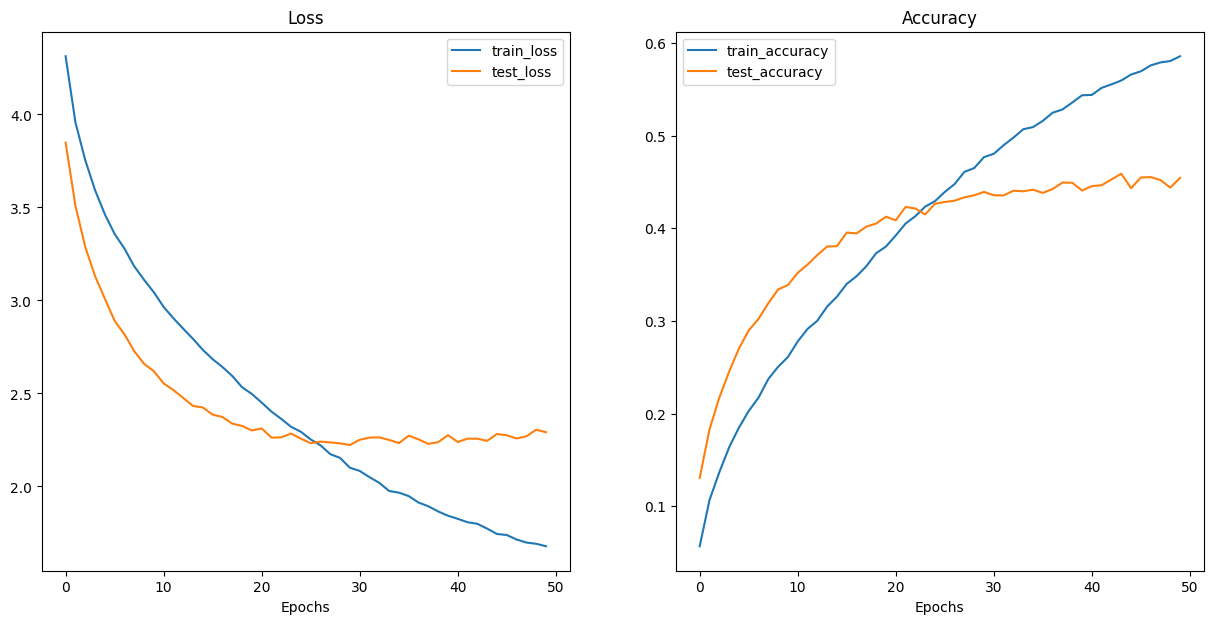

In [33]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_densenet = get_densenet_model().to(device=device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_densenet.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  # train model
  model_densenet_results = train(
      model=model_densenet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_info=f"densenet_lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}",
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_densenet_results)
  cur+=1
  print()

### EfficientNet-B0

In [28]:
# Hyperparms
# lr = [1e-3,1e-4] # learning rate
# betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
# weight_decay = [1e-3] # weight decay (L2 penalty)

# Best parms: Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001
lr = [1e-4] # learning rate
betas=[(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)

parms_combs = [(l,b,e,w_d) for l in lr for b in betas for e in eps for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 50

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=100).to(device=device)

current exp / total: 1 / 1
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.6227 | train_acc: 0.0137 | test_loss: 4.5729 | test_acc: 0.0128
Epoch: 2 | train_loss: 4.5708 | train_acc: 0.0165 | test_loss: 4.5244 | test_acc: 0.0205
Epoch: 3 | train_loss: 4.5214 | train_acc: 0.0228 | test_loss: 4.4281 | test_acc: 0.0310
Epoch: 4 | train_loss: 4.4339 | train_acc: 0.0303 | test_loss: 4.2844 | test_acc: 0.0521
Epoch: 5 | train_loss: 4.3433 | train_acc: 0.0407 | test_loss: 4.1510 | test_acc: 0.0752
Epoch: 6 | train_loss: 4.2649 | train_acc: 0.0517 | test_loss: 4.0472 | test_acc: 0.0891
Epoch: 7 | train_loss: 4.1940 | train_acc: 0.0615 | test_loss: 3.9402 | test_acc: 0.1048
Epoch: 8 | train_loss: 4.1356 | train_acc: 0.0692 | test_loss: 3.8409 | test_acc: 0.1131
Epoch: 9 | train_loss: 4.0722 | train_acc: 0.0779 | test_loss: 3.7788 | test_acc: 0.1273
Epoch: 10 | train_loss: 4.0126 | train_acc: 0.0854 | test_loss: 3.6942 | test_acc: 0.1459
Epoch: 11 | train_loss: 3.9554 | train_acc: 0.0965 | test_loss: 3.6193 | test_acc: 0.1607
Epoch: 12 | train_l

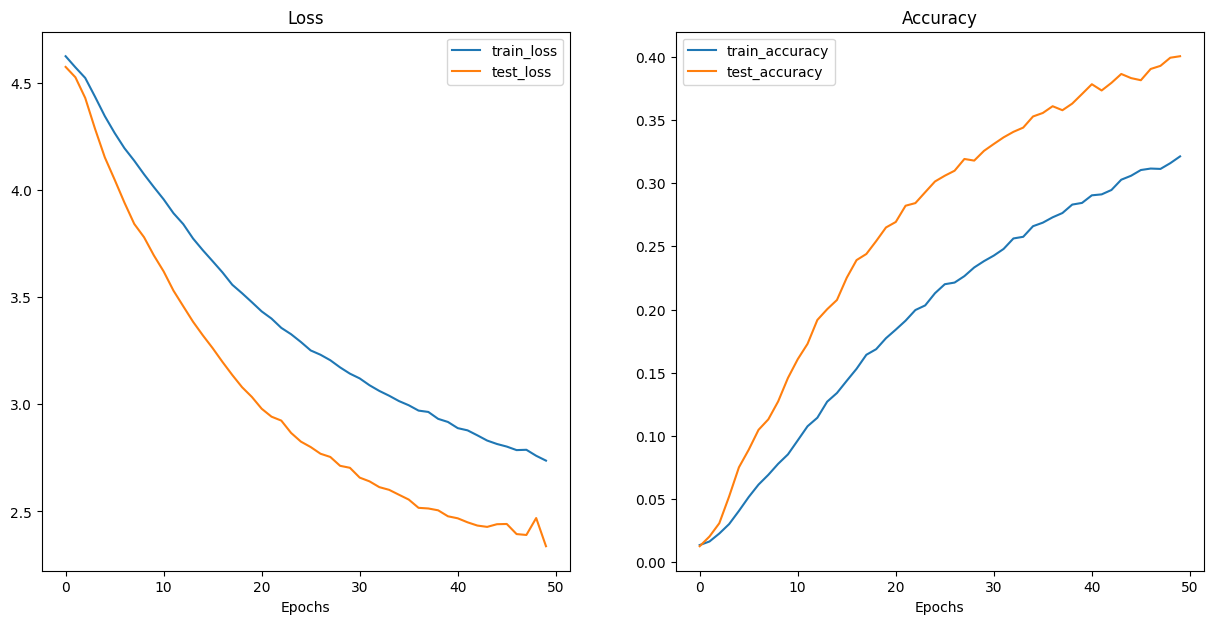

In [29]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_effnet = get_effnet_model().to(device=device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_effnet.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  # train model
  model_effnet_results = train(
      model=model_effnet,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_info=f"densenet_lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}",
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_effnet_results)
  cur+=1
  print()

### ConvNeXt-T

In [28]:
# Hyperparms
# lr = [1e-3,1e-4] # learning rate
# betas=[(0.8, 0.888),(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
# eps = [1e-8] # term added to the denominator to improve numerical stability
# weight_decay = [1e-3] # weight decay (L2 penalty)

# Best parms: Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001
lr = [1e-4] # learning rate
betas=[(0.9, 0.999)] # coefficients used for computing running averages of gradient and its square
eps = [1e-8] # term added to the denominator to improve numerical stability
weight_decay = [1e-3] # weight decay (L2 penalty)

parms_combs = [(l,b,e,w_d) for l in lr for b in betas for e in eps for w_d in weight_decay]
# print(parms_combs)

# init. epochs
NUM_EPOCHS = 50

# init. loss function, accuracy function and optimizer
loss_fn = nn.CrossEntropyLoss()
acc_fn = Accuracy(task="multiclass", num_classes=100).to(device=device)

current exp / total: 1 / 1
Training with: lr: 0.0001, betas: (0.9, 0.999), eps: 1e-08, weight_decay: 0.001


  0%|          | 0/50 [00:00<?, ?it/s]

Epoch: 1 | train_loss: 4.2251 | train_acc: 0.0797 | test_loss: 3.7578 | test_acc: 0.1593
Epoch: 2 | train_loss: 4.0329 | train_acc: 0.1145 | test_loss: 3.6538 | test_acc: 0.1732
Epoch: 3 | train_loss: 3.9527 | train_acc: 0.1287 | test_loss: 3.5763 | test_acc: 0.1871
Epoch: 4 | train_loss: 3.9044 | train_acc: 0.1388 | test_loss: 3.5162 | test_acc: 0.1971
Epoch: 5 | train_loss: 3.8454 | train_acc: 0.1478 | test_loss: 3.4653 | test_acc: 0.2020
Epoch: 6 | train_loss: 3.8100 | train_acc: 0.1543 | test_loss: 3.4326 | test_acc: 0.2165
Epoch: 7 | train_loss: 3.7833 | train_acc: 0.1606 | test_loss: 3.4346 | test_acc: 0.2077
Epoch: 8 | train_loss: 3.7514 | train_acc: 0.1667 | test_loss: 3.4041 | test_acc: 0.2158
Epoch: 9 | train_loss: 3.7415 | train_acc: 0.1698 | test_loss: 3.3828 | test_acc: 0.2124
Epoch: 10 | train_loss: 3.7245 | train_acc: 0.1753 | test_loss: 3.3725 | test_acc: 0.2193
Epoch: 11 | train_loss: 3.6933 | train_acc: 0.1798 | test_loss: 3.3722 | test_acc: 0.2166
Epoch: 12 | train_l

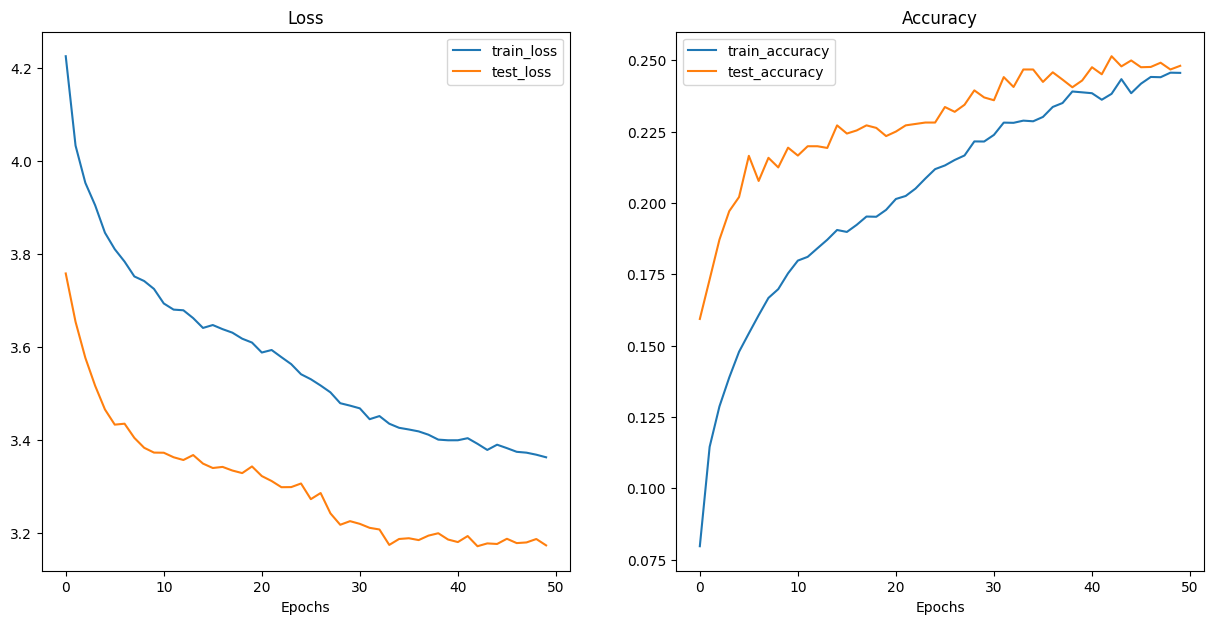

In [31]:
cur,total = 1, len(lr)*len(betas)*len(eps)*len(weight_decay)
for h_parms in parms_combs:
  ### INIT MODEL STARTS ###
  # traning same model for each parms
  model_convnext = get_convnext_model().to(device=device)
  ### INIT MODEL END ###

  optimizer = torch.optim.Adam(
      params=model_convnext.parameters(), lr=h_parms[0], betas=h_parms[1], eps=h_parms[2],weight_decay=h_parms[3]
  )

  # importing and init. the timer for checking model training time
  from timeit import default_timer as timer

  start_time = timer()
  print(f"current exp / total: {cur} / {total}")
  print(f"Training with: lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  # train model
  model_convnext_results = train(
      model=model_convnext,
      train_dataloader=train_dataloader,
      test_dataloader=test_dataloader,
      optimizer=optimizer,
      loss_fn=loss_fn,
      acc_fn=acc_fn,
      epochs=NUM_EPOCHS,
      save_info=f"densenet_lr_{h_parms[0]}_betas_{h_parms[1]}_eps_{h_parms[2]}_weight_decay_{h_parms[3]}",
  )

  # end timer
  end_time = timer()
  # printing time taken
  print(f"total training time: {end_time-start_time:.3f} sec.")
  # print("model stats:")
  # print(model_0_results)
  print(f"LOSS & Accuracy Curves\n"
        f"lr: {h_parms[0]}, betas: {h_parms[1]}, eps: {h_parms[2]}, weight_decay: {h_parms[3]}")
  plot_loss_curves(model_convnext_results)
  cur+=1
  print()

## Infrencing With Onnx

### ResNet-34

#### Loading the saved best model ResNet

In [35]:
MODEL_NAME = "ResNet_epoch_50_optim_adam_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"
model_resnet = get_resnet_model().to(device=device)
model_resnet.load_state_dict(torch.load(MODEL_NAME))
model_resnet.eval()
print("Model Loaded successfully")

Model Loaded successfully


#### Exporting model to onnx

In [36]:
dummy_input = torch.randn(128, 3, 32, 32).to(device=device)
input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model_resnet,
                 dummy_input,
                 "resnet34.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

#### loading and inferring on the model

In [37]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("resnet34.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs[0].shape)

# compare ONNX Runtime and PyTorch results
torch_out = model_resnet(dummy_input) #torch.randn(1, 3, 224, 224)
print(torch_out.shape)
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

(128, 100)
torch.Size([128, 100])


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 3457 / 12800 (27%)
Max absolute difference: 0.00483227
Max relative difference: 1.5685214
 x: array([[-0.83127 , -0.249052, -2.095519, ..., -1.394046, -2.277586,
         2.110539],
       [-1.014306, -0.270482, -1.737485, ..., -1.027353, -1.765285,...
 y: array([[-0.830775, -0.248689, -2.094972, ..., -1.393983, -2.277516,
         2.109488],
       [-1.014946, -0.271007, -1.737449, ..., -1.026818, -1.765561,...

### DenseNet-121

#### Loading the saved best model DenseNet

In [40]:
MODEL_NAME = "DenseNet_epoch_50_optim_adam_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"
model_densenet = get_densenet_model().to(device=device)
model_densenet.load_state_dict(torch.load(MODEL_NAME))
model_densenet.eval()
print("Model Loaded successfully")

Model Loaded successfully


#### Exporting model to onnx

In [41]:
dummy_input = torch.randn(128, 3, 32, 32).to(device=device)
input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model_densenet,
                 dummy_input,
                 "densenet121.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

#### loading and inferring on the model

In [42]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("densenet121.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs[0].shape)

# compare ONNX Runtime and PyTorch results
model_densenet.eval()
torch_out = model_densenet(dummy_input) #torch.randn(1, 3, 224, 224)
print(torch_out.shape)
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

(128, 100)
torch.Size([128, 100])


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 2507 / 12800 (19.6%)
Max absolute difference: 0.00370073
Max relative difference: 2.851312
 x: array([[-1.377174, -2.362814, -2.984988, ..., -2.246604, -2.135296,
         2.223649],
       [-1.300864, -2.440155, -2.657663, ..., -2.114394, -1.367235,...
 y: array([[-1.37648 , -2.36254 , -2.984989, ..., -2.246569, -2.135605,
         2.222578],
       [-1.300465, -2.43924 , -2.656173, ..., -2.113235, -1.366664,...

### EfficientNet-B0

#### Loading the saved best model DenseNet

In [44]:
MODEL_NAME = "EfficientNet_epoch_50_optim_adam_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"
model_effnet = get_effnet_model().to(device=device)
model_effnet.load_state_dict(torch.load(MODEL_NAME))
model_effnet.eval()
print("Model Loaded successfully")

Model Loaded successfully


#### Exporting model to onnx

In [45]:
dummy_input = torch.randn(128, 3, 32, 32).to(device=device)
input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model_effnet,
                 dummy_input,
                 "effnet_b0.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

#### loading and inferring on the model

In [46]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("effnet_b0.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs[0].shape)

# compare ONNX Runtime and PyTorch results
model_effnet.eval()
torch_out = model_effnet(dummy_input) #torch.randn(1, 3, 224, 224)
print(torch_out.shape)
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

(128, 100)
torch.Size([128, 100])


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 3255 / 12800 (25.4%)
Max absolute difference: 0.00549221
Max relative difference: 7.424084
 x: array([[-0.240425, -0.860548, -0.352838, ..., -0.508217, -1.711124,
         3.130223],
       [ 0.249967,  0.105939, -1.436937, ..., -0.040607, -1.492493,...
 y: array([[-0.240175, -0.86072 , -0.351628, ..., -0.506916, -1.710201,
         3.130523],
       [ 0.251792,  0.10605 , -1.437403, ..., -0.041532, -1.492966,...

### ConvNeXt-T

#### Loading the saved best model DenseNet

In [47]:
MODEL_NAME = "ConvNeXt_epoch_50_optim_adam_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"
model_convnext = get_convnext_model().to(device=device)
model_convnext.load_state_dict(torch.load(MODEL_NAME))
model_convnext.eval()
print("Model Loaded successfully")

Model Loaded successfully


#### Exporting model to onnx

In [48]:
dummy_input = torch.randn(128, 3, 32, 32).to(device=device)
input_names = [ "actual_input" ]
output_names = [ "output" ]

torch.onnx.export(model_convnext,
                 dummy_input,
                 "convnext_t.onnx",
                 verbose=False,
                 input_names=input_names,
                 output_names=output_names,
                 export_params=True,
                 )

#### loading and inferring on the model

In [49]:
import onnxruntime

ort_session = onnxruntime.InferenceSession("convnext_t.onnx")

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

# compute ONNX Runtime output prediction
ort_inputs = {ort_session.get_inputs()[0].name: to_numpy(dummy_input)}
ort_outs = ort_session.run(None, ort_inputs)
print(ort_outs[0].shape)

# compare ONNX Runtime and PyTorch results
model_convnext.eval()
torch_out = model_convnext(dummy_input) #torch.randn(1, 3, 224, 224)
print(torch_out.shape)
np.testing.assert_allclose(to_numpy(torch_out), ort_outs[0], rtol=1e-03, atol=1e-05)

(128, 100)
torch.Size([128, 100])


AssertionError: 
Not equal to tolerance rtol=0.001, atol=1e-05

Mismatched elements: 2430 / 12800 (19%)
Max absolute difference: 0.00167978
Max relative difference: 2.522309
 x: array([[-2.032904, -0.869442, -1.180609, ...,  0.090573, -0.745062,
        -0.766215],
       [ 0.518878,  1.416498,  0.317095, ..., -2.288239,  1.221057,...
 y: array([[-2.033229, -0.869741, -1.180246, ...,  0.090834, -0.745333,
        -0.766302],
       [ 0.51862 ,  1.416081,  0.316874, ..., -2.287298,  1.221458,...

## Infrencing with Onnx - Quantized

### installing req.

In [2]:
!pip -q install onnxoptimizer

### Exporting model to Static Graph Optimization

In [3]:
!python -m onnxoptimizer resnet34.onnx resnet34_opt.onnx

In [4]:
!python -m onnxoptimizer densenet121.onnx densenet121_opt.onnx

In [5]:
!python -m onnxoptimizer effnet_b0.onnx effnet_b0_opt.onnx

In [6]:
!python -m onnxoptimizer convnext_t.onnx convnext_t_opt.onnx

### Resnet-34

In [25]:
from time import perf_counter
import onnxruntime

dummy_input = torch.randn(1, 3, 224, 224)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def time_ort_model_evaluation(model_path):
    sess_options = onnxruntime.SessionOptions()
    sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
    session = onnxruntime.InferenceSession(model_path, sess_options)

    time_per_inference = []
    for _ in range(10):
        dummy_input = torch.randn(128, 3, 32, 32)
        # compute ONNX Runtime output prediction
        ort_inputs = {session.get_inputs()[0].name: to_numpy(dummy_input)}
        start = perf_counter()
        session.run(None, ort_inputs)
        time_per_inference.append((1000 * (perf_counter() - start)))

    return np.mean(time_per_inference)

print('Average runtime of ONNX Model in GPU: ' + str(time_ort_model_evaluation('resnet34.onnx')))
print('Average runtime of ONNX Optimized Model in GPU: ' + str(time_ort_model_evaluation('resnet34_opt.onnx')))


Average runtime of ONNX Model in GPU: 21.121726505225524
Average runtime of ONNX Optimized Model in GPU: 20.86290340521373


### Densenet-121

In [34]:
from time import perf_counter
import onnxruntime

dummy_input = torch.randn(1, 3, 224, 224)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def time_ort_model_evaluation(model_path):
    sess_options = onnxruntime.SessionOptions()
    sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
    session = onnxruntime.InferenceSession(model_path, sess_options)

    time_per_inference = []
    for _ in range(100):
        dummy_input = torch.randn(128, 3, 32, 32)
        # compute ONNX Runtime output prediction
        ort_inputs = {session.get_inputs()[0].name: to_numpy(dummy_input)}
        start = perf_counter()
        session.run(None, ort_inputs)
        time_per_inference.append((1000 * (perf_counter() - start)))

    return np.mean(time_per_inference)

print('Average runtime of ONNX Model in GPU: ' + str(time_ort_model_evaluation('densenet121.onnx')))
print('Average runtime of ONNX Optimized Model in GPU: ' + str(time_ort_model_evaluation('densenet121_opt.onnx')))


Average runtime of ONNX Model in GPU: 47.0255221897969
Average runtime of ONNX Optimized Model in GPU: 44.29885991674382


### Effnet-B0

In [33]:
from time import perf_counter
import onnxruntime

dummy_input = torch.randn(1, 3, 224, 224)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def time_ort_model_evaluation(model_path):
    sess_options = onnxruntime.SessionOptions()
    sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
    session = onnxruntime.InferenceSession(model_path, sess_options)

    time_per_inference = []
    for _ in range(100):
        dummy_input = torch.randn(128, 3, 32, 32)
        # compute ONNX Runtime output prediction
        ort_inputs = {session.get_inputs()[0].name: to_numpy(dummy_input)}
        start = perf_counter()
        session.run(None, ort_inputs)
        time_per_inference.append((1000 * (perf_counter() - start)))

    return np.mean(time_per_inference)

print('Average runtime of ONNX Model in GPU: ' + str(time_ort_model_evaluation('effnet_b0.onnx')))
print('Average runtime of ONNX Optimized Model in GPU: ' + str(time_ort_model_evaluation('effnet_b0_opt.onnx')))


Average runtime of ONNX Model in GPU: 82.28866720979568
Average runtime of ONNX Optimized Model in GPU: 82.96054206846748


### Convnext-T

In [32]:
from time import perf_counter
import onnxruntime

dummy_input = torch.randn(1, 3, 224, 224)

def to_numpy(tensor):
    return tensor.detach().cpu().numpy() if tensor.requires_grad else tensor.cpu().numpy()

def time_ort_model_evaluation(model_path):
    sess_options = onnxruntime.SessionOptions()
    sess_options.graph_optimization_level = onnxruntime.GraphOptimizationLevel.ORT_ENABLE_ALL
    session = onnxruntime.InferenceSession(model_path, sess_options)

    time_per_inference = []
    for _ in range(100):
        dummy_input = torch.randn(128, 3, 32, 32)
        # compute ONNX Runtime output prediction
        ort_inputs = {session.get_inputs()[0].name: to_numpy(dummy_input)}
        start = perf_counter()
        session.run(None, ort_inputs)
        time_per_inference.append((1000 * (perf_counter() - start)))

    return np.mean(time_per_inference)

print('Average runtime of ONNX Model in GPU: ' + str(time_ort_model_evaluation('convnext_t.onnx')))
print('Average runtime of ONNX Optimized Model in GPU: ' + str(time_ort_model_evaluation('convnext_t_opt.onnx')))


Average runtime of ONNX Model in GPU: 87.44522482040338
Average runtime of ONNX Optimized Model in GPU: 86.56301585258916


## Infrencing With TorchScript

In [16]:
# util functions to measure the execution time
from time import perf_counter
def timer(f,*args):   
    start = perf_counter()
    f(*args)
    return (1000 * (perf_counter() - start))

### ResNet-34

#### Loading the saved best model ResNet

In [17]:
MODEL_NAME = "ResNet_epoch_50_optim_adam_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"
model_resnet = get_resnet_model().to(device=device)
model_resnet.load_state_dict(torch.load(MODEL_NAME))
model_resnet.eval()
print("Model Loaded successfully")

Model Loaded successfully


#### Exporting model to torchscript

In [18]:
dummy_input = torch.randn(128, 3, 32, 32).to(device=device)
model_resnet_scripted = torch.jit.script(model_resnet)
print(model_resnet(dummy_input))
print(model_resnet_scripted(dummy_input))

tensor([[-0.9485, -0.2323, -1.8176,  ..., -1.2790, -2.2195,  0.8974],
        [-2.1515, -0.9295, -2.1435,  ..., -1.2413, -2.5740,  1.9220],
        [-1.4897, -0.5094, -1.9372,  ..., -1.0663, -2.4463,  1.8692],
        ...,
        [-1.7910,  0.0331, -2.0149,  ..., -0.6805, -1.8745,  2.4657],
        [-0.4150,  0.3973, -1.6915,  ..., -0.4103, -1.2566, -0.0619],
        [-1.6356, -0.8844, -1.9820,  ..., -2.1904, -2.2972,  1.7448]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-0.9485, -0.2323, -1.8176,  ..., -1.2790, -2.2195,  0.8974],
        [-2.1515, -0.9295, -2.1435,  ..., -1.2413, -2.5740,  1.9220],
        [-1.4897, -0.5094, -1.9372,  ..., -1.0663, -2.4463,  1.8692],
        ...,
        [-1.7910,  0.0331, -2.0149,  ..., -0.6805, -1.8745,  2.4657],
        [-0.4150,  0.3973, -1.6915,  ..., -0.4103, -1.2566, -0.0619],
        [-1.6356, -0.8844, -1.9820,  ..., -2.1904, -2.2972,  1.7448]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


#### loading and inferring on the model

In [19]:
print(f"Average runtime of Pytorch Model on Device: {device}: " + str(np.mean([timer(model_resnet,dummy_input) for _ in range(100)])))
print(f"Average runtime of TorchScript Model on Device: {device}: " + str(np.mean([timer(model_resnet_scripted,dummy_input) for _ in range(100)])))

Average runtime of Pytorch Model on Device: cuda: 5.322201989765745
Average runtime of TorchScript Model on Device: cuda: 3.9818819795618765


### DenseNet-121

#### Loading the saved best model DenseNet

In [21]:
MODEL_NAME = "./DenseNet_epoch_50_optim_adam_densenet_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"
model_densenet = get_densenet_model().to(device=device)
model_densenet.load_state_dict(torch.load(MODEL_NAME))
model_densenet.eval()
print("Model Loaded successfully")

Model Loaded successfully


#### Exporting model to torchscript

In [22]:
dummy_input = torch.randn(128, 3, 32, 32).to(device=device)
model_densenet_scripted = torch.jit.script(model_densenet)
print(model_densenet(dummy_input))
print(model_densenet_scripted(dummy_input))

tensor([[-1.9311, -2.6168, -2.5879,  ..., -2.4728, -1.0319,  2.2238],
        [-0.2390, -1.7111, -1.7997,  ..., -1.6005, -0.6442,  1.0207],
        [-1.6695, -2.4689, -2.8862,  ..., -2.1540, -1.3870,  1.1823],
        ...,
        [-1.0969, -2.6198, -3.1459,  ..., -2.1489, -1.7674,  1.0646],
        [-0.9965, -2.4515, -2.5753,  ..., -1.2252, -1.2290,  2.3016],
        [-1.1743, -2.5648, -2.5751,  ..., -2.1498, -1.2191,  1.3147]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.9311, -2.6168, -2.5879,  ..., -2.4728, -1.0319,  2.2238],
        [-0.2390, -1.7111, -1.7997,  ..., -1.6005, -0.6442,  1.0207],
        [-1.6695, -2.4689, -2.8862,  ..., -2.1540, -1.3870,  1.1823],
        ...,
        [-1.0969, -2.6198, -3.1459,  ..., -2.1489, -1.7674,  1.0646],
        [-0.9965, -2.4515, -2.5753,  ..., -1.2252, -1.2290,  2.3016],
        [-1.1743, -2.5648, -2.5751,  ..., -2.1498, -1.2191,  1.3147]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


#### loading and inferring on the model

In [23]:
print(f"Average runtime of Pytorch Model on Device: {device}: " + str(np.mean([timer(model_resnet,dummy_input) for _ in range(100)])))
print(f"Average runtime of TorchScript Model on Device: {device}: " + str(np.mean([timer(model_resnet_scripted,dummy_input) for _ in range(100)])))

Average runtime of Pytorch Model on Device: cuda: 5.401335280039348
Average runtime of TorchScript Model on Device: cuda: 3.910312571679242


### EfficientNet-B0

#### Loading the saved best model Effnet

In [26]:
MODEL_NAME = "./EfficientNet_epoch_50_optim_adam_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"
model_effnet = get_effnet_model().to(device=device)
model_effnet.load_state_dict(torch.load(MODEL_NAME))
model_effnet.eval()
print("Model Loaded successfully")

Model Loaded successfully


#### Exporting model to torchscript

In [29]:
dummy_input = torch.randn(128, 3, 32, 32).to(device=device)
model_effnet_scripted = torch.jit.script(model_effnet)
print(model_effnet(dummy_input))
print(model_effnet_scripted(dummy_input))

tensor([[ 0.2533,  0.2101, -0.7960,  ..., -0.4929, -0.7527,  0.7382],
        [-0.9185, -0.3297, -0.4060,  ...,  0.3517, -0.5454,  0.7316],
        [ 0.1248,  0.2743, -0.6888,  ...,  0.0422, -1.5328,  0.3006],
        ...,
        [ 0.0050, -0.4140, -1.5111,  ..., -0.2804, -1.9844,  1.5874],
        [-0.1531, -0.1204, -0.7915,  ..., -0.2842, -1.1549,  0.4243],
        [-0.0444, -0.6863, -0.8218,  ..., -0.1936, -1.0138,  0.8806]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[ 0.2533,  0.2101, -0.7960,  ..., -0.4929, -0.7527,  0.7382],
        [-0.9185, -0.3297, -0.4060,  ...,  0.3517, -0.5454,  0.7316],
        [ 0.1248,  0.2743, -0.6888,  ...,  0.0422, -1.5328,  0.3006],
        ...,
        [ 0.0050, -0.4140, -1.5111,  ..., -0.2804, -1.9844,  1.5874],
        [-0.1531, -0.1204, -0.7915,  ..., -0.2842, -1.1549,  0.4243],
        [-0.0444, -0.6863, -0.8218,  ..., -0.1936, -1.0138,  0.8806]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


#### loading and inferring on the model

In [30]:
print(f"Average runtime of Pytorch Model on Device: {device}: " + str(np.mean([timer(model_resnet,dummy_input) for _ in range(100)])))
print(f"Average runtime of TorchScript Model on Device: {device}: " + str(np.mean([timer(model_resnet_scripted,dummy_input) for _ in range(100)])))

Average runtime of Pytorch Model on Device: cuda: 5.281439067039173
Average runtime of TorchScript Model on Device: cuda: 3.8354573902324773


### ConvNext-T

#### Loading the saved best model convnext

In [32]:
MODEL_NAME = "./ConvNeXt_epoch_50_optim_adam_lr_0.0001_betas_(0.9, 0.999)_eps_1e-08_weight_decay_0.001.pth"
model_convnext = get_convnext_model().to(device=device)
model_convnext.load_state_dict(torch.load(MODEL_NAME))
model_convnext.eval()
print("Model Loaded successfully")

Model Loaded successfully


#### Exporting model to torchscript

In [33]:
dummy_input = torch.randn(128, 3, 32, 32).to(device=device)
model_convnext_scripted = torch.jit.script(model_convnext)
print(model_convnext(dummy_input))
print(model_convnext_scripted(dummy_input))

tensor([[-1.4304, -0.4490,  0.4542,  ..., -0.1554,  0.4002, -0.2090],
        [-1.1872,  2.2010, -0.4837,  ..., -2.1678,  1.4963,  0.8558],
        [-1.4944,  0.4413, -0.9438,  ..., -2.5317, -0.2114,  0.3555],
        ...,
        [-1.6544, -0.6342, -0.4902,  ...,  0.6588, -0.0620,  0.4840],
        [ 0.1696,  0.6508, -0.7577,  ..., -2.0573,  1.6224,  0.9046],
        [-0.7419,  0.8702,  0.4180,  ..., -2.2167,  2.6272, -0.5041]],
       device='cuda:0', grad_fn=<AddmmBackward0>)
tensor([[-1.4304, -0.4490,  0.4542,  ..., -0.1554,  0.4002, -0.2090],
        [-1.1872,  2.2010, -0.4837,  ..., -2.1678,  1.4963,  0.8558],
        [-1.4944,  0.4413, -0.9438,  ..., -2.5317, -0.2114,  0.3555],
        ...,
        [-1.6544, -0.6342, -0.4902,  ...,  0.6588, -0.0620,  0.4840],
        [ 0.1696,  0.6508, -0.7577,  ..., -2.0573,  1.6224,  0.9046],
        [-0.7419,  0.8702,  0.4180,  ..., -2.2167,  2.6272, -0.5041]],
       device='cuda:0', grad_fn=<AddmmBackward0>)


#### loading and inferring on the model

In [34]:
print(f"Average runtime of Pytorch Model on Device: {device}: " + str(np.mean([timer(model_resnet,dummy_input) for _ in range(100)])))
print(f"Average runtime of TorchScript Model on Device: {device}: " + str(np.mean([timer(model_resnet_scripted,dummy_input) for _ in range(100)])))

Average runtime of Pytorch Model on Device: cuda: 5.256765678932425
Average runtime of TorchScript Model on Device: cuda: 3.82415242085699
